# News Headline Categorisation Project
You've learned various ways to work with Textual data and build a reasonable Movie Review Sentiment Predictor. In this workbook you are going to use all that you have previously learned to tackle a Document Classification task. 

This project is based on the Kaggle Challenge https://www.kaggle.com/rmisra/news-category-dataset

In this project you will take data about news articles and build a model to classify them into one of a number of News Categories such as Crime, Entertainment, Travel and so on.

As this is a Project, you will have more time to complete this workbook but at the same time there is less guidance in the workbook.

# Import some packages
These are the packages we will (most probably) need to complete this task

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import os
import numpy as np

In [ ]:
# download pretrained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip the file
!unzip glove.6B.zip

## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [102]:
def load_glove_file_embeddings():
    # Extract the Embeddings
    glove_file = os.path.join('.', 'glove.6B.100d.txt')
    embeddings_index = {}
    f = open(glove_file, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

def get_embedding_layer():
    embeddings_index = load_glove_file_embeddings()
    
    # prepare embedding matrix
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = keras.layers.Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    return embedding_layer

def printLossAndAccuracy(history):
  import matplotlib.pyplot as plt
  history_dict = history.history

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.show()

  plt.clf()   # clear figure

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


  plt.show()

def prepare_test_seq(text):
    test_seq = tokenizer.texts_to_sequences([text])
    # Pad the data
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq, 
                                                         padding='post',
                                                         truncating='post',
                                                         maxlen=MAX_SEQUENCE_LENGTH)
    return test_seq

def output_most_likely(categories, preds):
    likely = np.argmax(preds);
    print("Most likely to be {} with {:2f} likelihood".format(categories[likely], preds[likely]) )

def output_category_probs(categories, preds):
    for i in range(len(categories)):
        print("{:20}: {:2f}".format(categories[i], preds[i]))
    


# Get the Data
The data is in a JSON file but we can load this easily into a Pandas DataFrame.

In [44]:
data = pd.read_json('News_Category_Dataset_v2.json', lines=True)
data.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


# Data Pre-Processing
For our purpose we will don't need features such as the authors, date and link so we can drop all the other features.

## Exercise
To construct a news classifier, we can use the _headline_ feature and we will use the _category_ as our target labels. The _headline_ feature contains only the headline for the news article and some additional information is given in the _short_description_

We have engineered a new feature _summary_ that combines the _headline_ and _short_description_ into a single feature.

You can either:
- use the _headline_ feature
- use the _short_description_ feature
- use the _summary_ feature

__Note__ there is sufficient time for this exercise that you can do both by re-running the workbook and making the change

In [46]:
# Create a new feature combining headline and short_description
data['summary'] = data['headline'].str.cat(data['short_description'],sep=" ")

# TODO: Specify the columns you want to drop
# We have specified the first few, so add to this list to drop more
# Remember you only want to have a single feature to train from and a single target label (category)
#features_to_drop = ['authors', 'date', 'link']
features_to_drop = ['authors', 'date', 'link', 'short_description', 'summary']


# Drop the columns we are not interested in
data.drop(features_to_drop, axis=1, inplace=True)
data.head()

KeyError: 'short_description'

## Limiting Categories
Running the cell below you will see a summary of the categories and the number of articles in each.
We can train to classify all of these but some categories have much fewer articles and so are unlikely to be learned well.

One option is to get more data but that is not feasible within the context of this exercise.

Another option is to limit our Categories to the top categories only

In [47]:
categories = data.groupby('category').size().sort_values(ascending=False)
print(categories)

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
dtype: 

### Exercise
Review the list above and decide how many categories you want your classifier to work with

In [48]:
# TODO: Set the TOP_N_CATEGORIES to some suitable value
TOP_N_CATEGORIES = 7

# Delete records that are not in the top categories
data = data[data.category.apply(lambda x: x in categories.index[:TOP_N_CATEGORIES]) &\
            (data.headline.apply(len) > 0)]

data.groupby('category').size().sort_values(ascending=False)

category
POLITICS          32738
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
dtype: int64

## Encoding our target labels
If you run the cell below and examine our _category_ feature you will notice that it is Textual data but we known that machines only understand numbers.

We will be dealing with our training features soon but for now we will focus on our category.

In [49]:
data.tail()

,category,headline
200805,WELLNESS,This Is Only the Beginning: Surprising Advice ...
200806,STYLE & BEAUTY,Cheryl Tiegs In A Sauna: A Look Back
200807,PARENTING,Teen Responsibility Doesn't Happen -- It's Nur...
200838,ENTERTAINMENT,"Sundance, Ice-T, and Shades of the American Ra..."
200839,ENTERTAINMENT,'Girl With the Dragon Tattoo' India Release Ca...


To ensure we can learn from this data we will do two things:
- Extract the set of textual labels into a variable called __category_labels__
- Convert the textual labels in our dataset to be a numberical index that maps to the _category_labels_

We will do this using the Pandas _get_dummies()_ method to one-hot-encode the labels and then create a new column in our dataset with the index.

In [50]:
# Here we one-hot-encode our labels
dummies = pd.get_dummies(data['category'])
# We extract our category labels
category_labels = dummies.columns.values
# We update our category feature to be the index of the category
data['category'] = dummies.values.argmax(1)

print(category_labels)
data.tail()



['ENTERTAINMENT' 'HEALTHY LIVING' 'PARENTING' 'POLITICS' 'STYLE & BEAUTY'
 'TRAVEL' 'WELLNESS']


C:\Users\Bill\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,category,headline
200805,6,This Is Only the Beginning: Surprising Advice ...
200806,4,Cheryl Tiegs In A Sauna: A Look Back
200807,2,Teen Responsibility Doesn't Happen -- It's Nur...
200838,0,"Sundance, Ice-T, and Shades of the American Ra..."
200839,0,'Girl With the Dragon Tattoo' India Release Ca...


## Preparing our training features
We are now going to Tokenise and Pad our training features. This involves a few steps
- Create a Tokeniser based on the words in our data
- Tokenise our training feature
- Pad/Truncate our training feature to a uniform length

### Exercise
Decide:
- how many words you want to be training against (somewhere in the range of 10,000 to 20,000 is good)
- the maximum sequence length you want to use

Once decided, update the variables below to reflect your choices

Depending upon the column you chose as your training feature set the value of the _training_feature_ variable to this name

In [51]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

training_feature = 'headline'

We are now going to create a tokeniser based on the words in our training feature

In [53]:
# Create a tokeniser
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data[training_feature])

Now we will create the Tokenised versions of our sequences and add them as a column in our dataset

In [55]:
# Tokenise the data
feature_seq = tokenizer.texts_to_sequences(data[training_feature])

# Pad the data
feature_seq = keras.preprocessing.sequence.pad_sequences(feature_seq, 
                                                         padding='post',
                                                         truncating='post',
                                                         maxlen=MAX_SEQUENCE_LENGTH)

# Add the sequences to our data
data['padded_feature_seq'] = feature_seq.tolist()
data.tail()

,category,headline,padded_feature_seq
200805,6,This Is Only the Beginning: Surprising Advice ...,"[24, 8, 299, 1, 3410, 846, 630, 18, 3, 0, 0, 0..."
200806,4,Cheryl Tiegs In A Sauna: A Look Back,"[6174, 5, 3, 3, 115, 95, 0, 0, 0, 0, 0, 0, 0, ..."
200807,2,Teen Responsibility Doesn't Happen -- It's Nur...,"[515, 3267, 232, 1238, 103, 0, 0, 0, 0, 0, 0, ..."
200838,0,"Sundance, Ice-T, and Shades of the American Ra...","[3453, 1078, 1125, 6, 2367, 4, 1, 144, 298, 5,..."
200839,0,'Girl With the Dragon Tattoo' India Release Ca...,"[6252, 11, 1, 7818, 2170, 779, 3577, 35, 1346,..."


## Create our Train and Test split
We can now split our data into Training and Test datasets

In [61]:
# Split the data randomly with a 20% Test set
data_train, data_test = train_test_split(data, test_size=0.2)

# Create the X and y data for train and test
X_train = np.array(data_train['padded_feature_seq'].values)
y_train = data_train['category']

X_test = np.array(data_test['padded_feature_seq'].values)
y_test = data_test['category']

# Designing your Model
We are now in a position to design our model. The design of this model is up to you but you will need:
- An Embedding Layer
    - You can train your own using the __Embedding__ layer
    - Load and use a Pre-trained Embedding layer using the the __get_embedding_layer()__ function
- A Classifer
   - You can use a set of Dense Layers
   - You can use a set of CNN Layers
   - You can use a LSTM Layer

Work in your groups to decide which combinations you want to design and complete the cell below with your design

In [66]:
# Classification using CNN
model = keras.Sequential()

# Input Layer
model.add(keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
# TODO: Your Choice of Embedding layer here
model.add( get_embedding_layer())

# Hidden Layers
# TODO: Your Choice of Classifier here
#model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# Output Layer
model.add(tf.keras.layers.Flatten())
model.add(keras.layers.Dense(len(category_labels), activation=tf.nn.sigmoid))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

# Print the Summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 11207     
Total params: 2,020,839
Trainable params: 20,839
Non-trainable params: 2,000,000
_________________________________________________________________


# Train your model
You should now be able to train your model.

## Exercise
Decide on 
- The maximum number of epochs you want to train for
    - We are using Early Stopping so this is the maxium number of epochs - we are likely to stop before reaching this...but you never know
- How patient you want to be above stopping
    - the higher the number the more patient you are and more likely to train for the full max epochs

In [68]:
# TODO:
# Decide how many epochs to train for
# Decide how much patience we should have before deciding to stop early
max_epochs = 50
stopping_patience = 10

# Stop early if our Validation Loss stagnates
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=stopping_patience)

# Train our model
history = model.fit(X_train_padded,
                    y_train,
                    epochs=max_epochs,
                    batch_size=512,
                    validation_split = 0.2,
                   callbacks=[early_stop])
print("Training Done")

Train on 64979 samples, validate on 16245 samples
Epoch 1/50
64979/64979 [==============================] - 18s 272us/sample - loss: 1.7820 - acc: 0.3215 - val_loss: 1.8109 - val_acc: 0.3281
Epoch 2/50
64979/64979 [==============================] - 15s 236us/sample - loss: 1.7758 - acc: 0.3219 - val_loss: 1.8179 - val_acc: 0.3275
Epoch 3/50
64979/64979 [==============================] - 14s 222us/sample - loss: 1.7691 - acc: 0.3225 - val_loss: 1.8245 - val_acc: 0.3244
Epoch 4/50
64979/64979 [==============================] - 21s 323us/sample - loss: 1.7630 - acc: 0.3230 - val_loss: 1.8258 - val_acc: 0.3216
Epoch 5/50
64979/64979 [==============================] - 19s 294us/sample - loss: 1.7561 - acc: 0.3237 - val_loss: 1.8354 - val_acc: 0.3197
Epoch 6/50
64979/64979 [==============================] - 18s 270us/sample - loss: 1.7504 - acc: 0.3253 - val_loss: 1.8410 - val_acc: 0.3132
Epoch 7/50
64979/64979 [==============================] - 17s 267us/sample - loss: 1.7458 - acc: 0.3258 

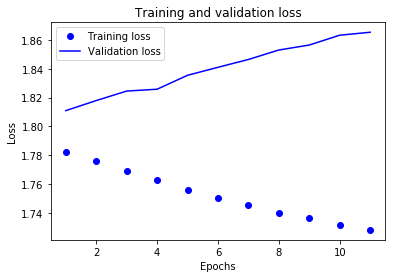

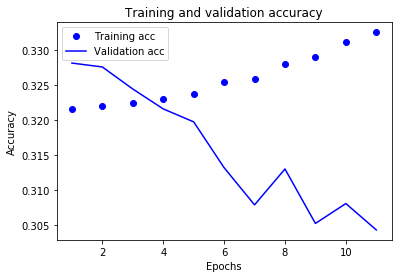

In [76]:
printLossAndAccuracy(history)

# Evaluate the model
We will now evaluate our model against a set of previously unseen reviews

In [15]:
val_loss, val_acc = model.evaluate(X_test_padded, y_test)

print ("Test Loss:", val_loss)
print ("Test Accuracy:", val_acc)

### Exercise
In your teams, consider the task we have been working on (classifying News Headlines into Categories) and consider the following questions:

- What would be the Human Level Performance for this task? 
- How did your model do compared to that expectation?
- Within your team, what worked wel and want didn't work well?
 
 
If your model hasn't performed as well as you think it could have then consider:
- Training for longer (but watch for overfitting)
- Train with a different network design
- Think about how you might be able to Engineer better features to train with

Try one or more of these out by rerunning the relevant workbook cells 

# Test the model
# Testing your model
Testing a model is different to evaluating a model - with evaluation we are measuring how good the model is against the data. With testing we are interested in evaluating risks that might affect the model.

## Exercise
Consider the purpose of our model, which is to predict the category for a News Article based on the header/summary. Our Evaluation on the model has given us a measure of accuracy but is that enough?

In this exercise, work in your teams to build an outline Test Strategy/Approach for the model. In particular consider:
- What are the product risk associated with the Model
- What additional testing would you recommend? 
    - See section below on Hypothosis Testing for one possible approach
- What Oracles could you use to check your model's predictions against?
- How should you evaluate your predictions?

### Hypothosis Testing
One approach to consider is to think in terms of what Hypotheses you have about the problem domain. These are statements you think should be true about the model's predictions such as:
- Headlines that have known politicians and use political words should be classes as Politics 

Sometimes these are known as _Good-old Fashioned Common Sense_ tests - things that ought to be true and we want to test our model to ensure it is consistent with these views.

If you think about the problem domain you can probably come up with a number of such hypotheses.

For each Hypothosis:
 - Consider how you would test it - what tests, how many is enough
 - How you evaluate the outcome of a test - should we look at the most probable category or look at the top 2 or 3 most probable?

## Exercise
Use the cell below to run some of your tests and evaluate the results

In [107]:
# Enter your test text
test_text = "BBC's decision to reprimand Naga Munchetty sparks backlash from stars"

# Prepare text sequence (tokenise and padd)
test_seq = prepare_test_seq(test_text)

# Make a prediction
preds = model.predict(prepare_test_seq(test_text))

# Output Results
output_most_likely(category_labels, preds[0])
output_category_probs(category_labels, preds[0])

Most likely to be POLITICS with 0.387743 likelihood
ENTERTAINMENT       : 0.153675
HEALTHY LIVING      : 0.049271
PARENTING           : 0.073804
POLITICS            : 0.387743
STYLE & BEAUTY      : 0.080889
TRAVEL              : 0.023323
WELLNESS            : 0.331522


## Exercise
In your teams, prepre a short report (5-8 mins) that outlines:
- The model you found worked best
- Your Testing Strategy
- Your Key Findings

We will then present to each other and debrief